In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
from dataclasses import asdict
from datetime import datetime
import cartopy.crs as ccrs
import easygems.healpix as egh
import intake
import matplotlib.pyplot as plt
import numpy as np
import orcestra
import orcestra.flightplan as fp
import orcestra.sat
from orcestra.flightplan import LatLon, IntoCircle, bco, sal, mindelo, find_ec_lon, vertical_preview, to_kml, ec_time_at_lat

# Global coordinates and definitions that should not change from flight to flight

lon_min, lon_max, lat_min, lat_max = -65, -5, -5, 25

radius = 133e3
atr_radius = 70e3

band = "east"
airport = sal if band == "east" else bco
natal = LatLon(-5 - 47/60. - 42.00/3600.,-35 - 12/60. - 33.98/3600., label = "natal")

In [61]:
# Basic information
lon_min, lon_max, lat_min, lat_max = -65, -5, -5, 25

# Define dates for forecast initialization and flight

issued_time = datetime(2024, 8, 25, 0, 0, 0)

flight_time = datetime(2024, 8, 29, 12, 0, 0)
flight_index = f"HALO-{flight_time.strftime('%Y%m%d')}a"

# adjust takeoff time to match EC overpass
takeoff_time = np.datetime64("2025-08-29T12:20:00.0")

print(
    f"Initalization date of IFS forecast: {issued_time}\n"
    f"Flight date: {flight_time:%Y-%m-%d}\n"
    f"Flight index: {flight_index}"
)

crew = {'Mission PI': 'Silke Groß',
        'DropSondes': 'Helene Glöckner',
        'HAMP': 'Clara Bayley',
        'SMART/VELOX': 'Kevin Wolf',
        'SpecMACS': 'Zekican Demiralay',
        'WALES' : 'Georgios Dekoutsidis',
        'Flight Documentation': 'Nicola Rochetin',
        'Ground Support': 'Marius Rixen',
        }

Initalization date of IFS forecast: 2024-08-25 00:00:00
Flight date: 2024-08-29
Flight index: HALO-20240829a


In [62]:
# Load forecast data
cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/internal.yaml")
ds = cat.HIFS(datetime = issued_time).to_dask().pipe(egh.attach_coords)

# Load ec satellite track for 
ec_track = orcestra.sat.SattrackLoader("EARTHCARE", "2024-08-26", kind="PRE").get_track_for_day(f"{flight_time:%Y-%m-%d}")
ec_track = ec_track.sel(time=slice(f"{flight_time:%Y-%m-%d} 06:00", None))
ec_lons, ec_lats = ec_track.lon.values, ec_track.lat.values

**Waypoint definitions**

In [63]:
mindelo

LatLon(lat=16.87781, lon=-24.995002, label='MINDELO', fl=0, time=None)

In [72]:
# Latitudes where we enter and leave the ec track (visually estimated)
lat_ec_north = 15.0
lat_ec_south = 2.5

# latitude of circle centers
lat_c_south_s = 3.5
lat_c_south = 4.5
lat_c_south_n = 5.5
lat_c_north = 13.0
lat_c_north_s = 12.0

lat_c_mid_s = 7.5
lat_c_mid = 8.5
lat_c_mid_n = 9.5

lat_ec_under = 5.0

#c_atr_nw = LatLon(17.433,-23.500, label = "c_atr")
#c_atr_se = LatLon(16.080,-21.715, label = "c_atr")

c_atr_nw = LatLon(18.58125000,-24.27616667, label = "c_atr")
c_atr_se = LatLon(15.79318333,-24.82891944, label = "c_atr")

# create ec track
ec_north = LatLon(lat_ec_north, find_ec_lon(lat_ec_north, ec_lons, ec_lats), label = "ec_north")
ec_south = LatLon(lat_ec_south, find_ec_lon(lat_ec_south, ec_lons, ec_lats), label = "ec_south")

# create circles
c_north = LatLon(lat_c_north, find_ec_lon(lat_c_north, ec_lons, ec_lats), label = "c_north")
c_north_alt_s = LatLon(lat_c_north_s, find_ec_lon(lat_c_north_s, ec_lons, ec_lats), label = "c_north_alt_s")

c_south = LatLon(lat_c_south, find_ec_lon(lat_c_south, ec_lons, ec_lats), label = "c_south")
c_south_s = LatLon(lat_c_south_s, find_ec_lon(lat_c_south_s, ec_lons, ec_lats), label = "c_south_s")
c_south_n = LatLon(lat_c_south_n, find_ec_lon(lat_c_south_n, ec_lons, ec_lats), label = "c_south_n")

c_mid = LatLon(lat_c_mid, find_ec_lon(lat_c_mid, ec_lons, ec_lats), label = "c_mid")
c_mid_s = LatLon(lat_c_mid_s, find_ec_lon(lat_c_mid_s, ec_lons, ec_lats), label = "c_mid_s")
c_mid_n = LatLon(lat_c_mid_n, find_ec_lon(lat_c_mid_n, ec_lons, ec_lats), label = "c_mid_n")

# ec underpass
ec_under = LatLon(lat_ec_under, find_ec_lon(lat_ec_under, ec_lons, ec_lats), label = "ec_under")
ec_under = ec_under.assign(time=str(ec_time_at_lat(ec_track, ec_under.lat).values)+"Z")

# Define flight track
outbound_legs = [
     airport,
     mindelo,
     ec_north.assign(fl=410),
     ]

ec_legs = [
     IntoCircle(c_south.assign(fl=430), radius, 360),   
     ec_south.assign(fl=410),
     ec_under.assign(fl=450),
     IntoCircle(c_mid.assign(fl=430), radius, 360), 
     c_north_alt_s.assign(fl=430),
     IntoCircle(c_north.assign(fl=450), radius, 360),   
     ]
inbound_legs = [
     ec_north.assign(fl=450),
     IntoCircle(c_atr_nw.assign(fl=350), atr_radius, 360),
     IntoCircle(c_atr_se.assign(fl=350), atr_radius, 360),
     airport,
     ]

waypoints = outbound_legs + ec_legs + inbound_legs 

waypoint_centers = []
for point in waypoints:
    if isinstance(point, IntoCircle):
        point = point.center
    waypoint_centers.append(point)

path = fp.expand_path(waypoints, dx=10e3)

In [73]:
# extra way points off track

plan = path.isel(distance = path.waypoint_indices).to_dataframe().set_index("waypoint_labels")


xwp_2 = LatLon(lat_c_south-1, find_ec_lon(lat_c_south-1, ec_lons, ec_lats), label = "xwp2")
xwp_3 = LatLon(c_atr_nw.lat,c_atr_nw.lon, label = "xwp3")
extra_waypoints = [xwp_2,xwp_3]

notes = {'c_south_in':f' {radius/1852:2.0f} nm circle centered at {c_south.format_pilot()}, enter from north, CCW',
        'c_mid_in':f' {radius/1852:2.0f} nm circle centered at {c_mid.format_pilot()}, enter from north, CCW',
        'c_north_in':f' {radius/1852:2.0f} nm circle centered at {c_north.format_pilot()}, enter from south, CCW',
        'c_atr_in':f' {atr_radius/1852:2.0f} nm circle centered at {c_atr_se.format_pilot()}, enter from west, CW',
        'xwp2':'Alternative center for c_south',
        'xwp3':'Alternative center for c_atr',
         }


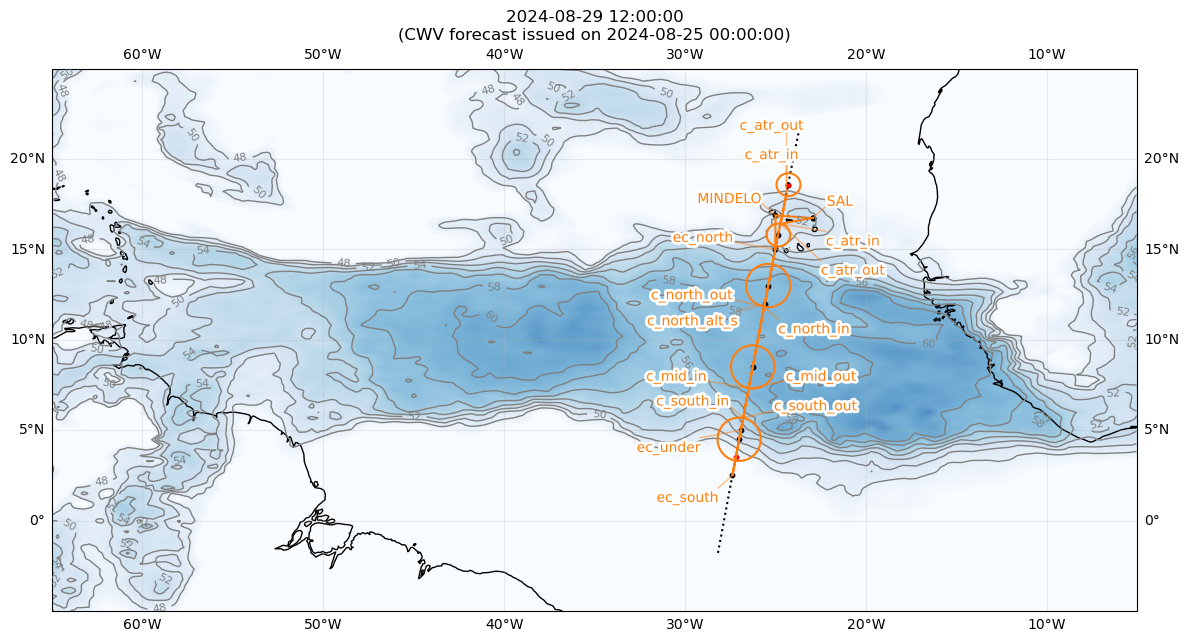

In [74]:
plt.figure(figsize = (14, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.coastlines(alpha=1.0)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

cwv_flight_time = ds["tcwv"].sel(time=flight_time, method = "nearest")
fp.plot_cwv(cwv_flight_time, levels = [48.0, 50.0, 52.0, 54.0, 56.0, 58.0, 60.0])
plt.title(f"{flight_time}\n(CWV forecast issued on {issued_time})")

plt.plot(ec_lons, ec_lats, c='k', ls='dotted')

if (False):
    plt.plot([natal.lon,sal.lon], [natal.lat,sal.lat], c='purple', ls='dashed')

for wp in waypoint_centers:
    plt.scatter(wp.lon,wp.lat,s=10.,color='k')
for wp in extra_waypoints:
    plt.scatter(wp.lon,wp.lat,s=10.,color='r',marker='o')
fp.plot_path(path, ax, color="C1")
plt.savefig(f'{flight_index}_track.png')

In [75]:
import pandas as pd

In [76]:
pd.DataFrame.from_records(map(asdict, [mindelo, 
                                       ec_north,
                                       ec_south,
                                       c_atr_nw,
                                       c_atr_se,
                                       ec_under,
                                       c_north,
                                       c_mid_n,
                                       c_mid_s,
                                       c_mid,
                                       c_south_n,
                                       c_south_s,
                                       c_south,
                                       mindelo
                                      ])).set_index("label")

,lat,lon,fl,time
label,,,,
MINDELO,16.877810,-24.995002,0.0,NaT
ec_north,15.000000,-25.007423,NaN,NaT
ec_south,2.500000,-27.378026,NaN,NaT
c_atr,18.581250,-24.276167,NaN,NaT
c_atr,15.793183,-24.828919,NaN,NaT
ec_under,5.000000,-26.911238,NaN,2024-08-29 15:51:38.696698+00:00
c_north,13.000000,-25.395257,NaN,NaT
c_mid_n,9.500000,-26.064101,NaN,NaT
c_mid_s,7.500000,-26.441985,NaN,NaT


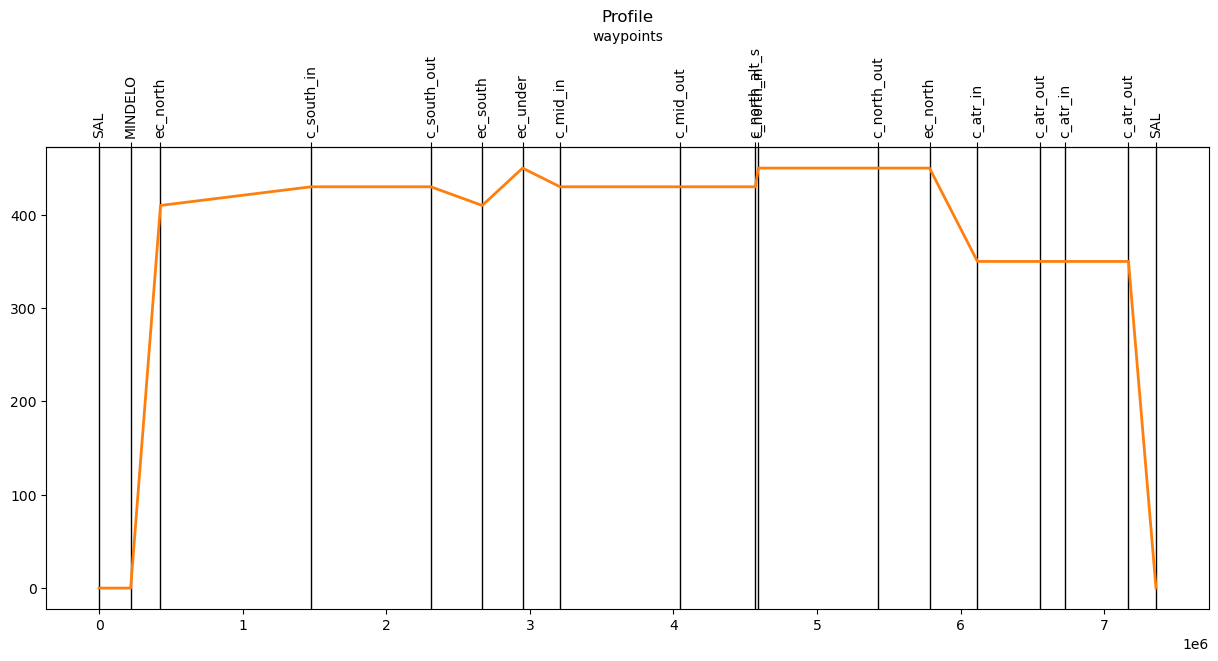

In [77]:
vertical_preview(waypoints)
plt.title("Profile")
plt.savefig(f'{flight_index}_profile.png')

In [78]:
plan

,waypoint_indices,distance,lon,lat,fl,speed,duration,time
waypoint_labels,,,,,,,,
SAL,0,0.000000e+00,-22.943974,16.734488,0.0,180.724333,0 days 00:00:00,2024-08-29 12:15:36.592523784
MINDELO,22,2.192022e+05,-24.995002,16.877810,0.0,180.724333,0 days 00:20:12.909298010,2024-08-29 12:35:49.501821794
ec_north,43,4.270015e+05,-25.007423,15.000000,410.0,234.380889,0 days 00:37:52.111817275,2024-08-29 12:53:28.704341059
c_south_in,148,1.475831e+06,-26.785339,5.682419,430.0,236.541556,0 days 01:52:06.505049295,2024-08-29 14:07:43.097573079
c_south_out,235,2.309801e+06,-26.785339,5.682419,430.0,236.541556,0 days 02:50:52.185656702,2024-08-29 15:06:28.778180486
ec_south,271,2.667813e+06,-27.378026,2.500000,410.0,234.380889,0 days 03:16:12.666091688,2024-08-29 15:31:49.258615472
ec_under,300,2.949081e+06,-26.911238,5.000000,450.0,238.445000,0 days 03:36:02.104174216,2024-08-29 15:51:38.696698000
c_mid_in,327,3.209916e+06,-26.476638,7.318195,430.0,236.541556,0 days 03:54:20.397208295,2024-08-29 16:09:56.989732079
c_mid_out,414,4.043886e+06,-26.476638,7.318195,430.0,236.541556,0 days 04:53:06.077869099,2024-08-29 17:08:42.670392883


In [79]:
# Detailed overview with notes
for index, row in plan.iterrows():
    if (index[0]+index[-4:]!='c_out'):
        print(f"{index:12s} {LatLon(row['lat'],row['lon']).format_pilot():20s}, FL{int(row['fl']):03d}, {row['time']:%H:%M:%S}, {notes.get(index,'')}" )
print ('\n-- circle centers:')
for point in waypoints:
    if isinstance(point, IntoCircle):
        point = point.center
        print (f'{point.label:12s} {point.format_pilot()}')
print ('\n-- extra waypoints:')
for point in extra_waypoints:
    print (f'{point.label:12s} {point.format_pilot()}, {notes.get(point.label,'')}' )
print ('\nCrew:')
for position,person in crew.items():
    print (f'{position:22s} {person}')

SAL          N16 44.07, W022 56.64, FL000, 12:15:36, 
MINDELO      N16 52.67, W024 59.70, FL000, 12:35:49, 
ec_north     N15 00.00, W025 00.45, FL410, 12:53:28, 
c_south_in   N05 40.95, W026 47.12, FL430, 14:07:43,  72 nm circle centered at N04 30.00, W027 00.29, enter from north, CCW
ec_south     N02 30.00, W027 22.68, FL410, 15:31:49, 
ec_under     N05 00.00, W026 54.67, FL450, 15:51:38, 
c_mid_in     N07 19.09, W026 28.60, FL430, 16:09:56,  72 nm circle centered at N08 30.00, W026 15.20, enter from north, CCW
c_north_alt_s N12 00.00, W025 35.25, FL430, 17:45:50, 
c_north_in   N11 49.12, W025 37.33, FL450, 17:47:16,  72 nm circle centered at N13 00.00, W025 23.72, enter from south, CCW
ec_north     N15 00.00, W025 00.45, FL450, 19:10:36, 
c_atr_in     N17 57.65, W024 24.29, FL350, 19:34:30,  38 nm circle centered at N15 47.59, W024 49.74, enter from west, CW
c_atr_in     N16 24.89, W024 42.50, FL350, 20:19:46,  38 nm circle centered at N15 47.59, W024 49.74, enter from west, CW
SAL  

### Export kml and text file for FX and pilots

In [82]:
with open(f"{flight_index}.kml", "w") as f:
    f.write(to_kml(path))

In [81]:
with open( f"{flight_index}_waypoints.txt", "w") as file:
    file.write(f"Flight {flight_index}\n\n")
    #
    # DM Format
    file.write("------------------------------------------------------------\n")
    file.write("\nDM Format:\n")
    file.write(" ".join(wp.format_1min() for wp in waypoint_centers) + "\n")
    for point in extra_waypoints:
        file.write(f"Extra waypoint: {point.format_1min()}\n")
    #
    # DM.mm format
    file.write("\n------------------------------------------------------------\n")
    file.write("\nDMmm Format:\n")
    for point in waypoint_centers:
        file.write(f"{point.format_pilot()}, {point.label}\n")
    file.write("\n-- extra waypoints:\n")
    for point in extra_waypoints:
        file.write(f"{point.format_pilot()}, {notes.get(point.label,'')}\n")
    #
    # Detailed overview with notes
    file.write("\n------------------------------------------------------------\n")
    file.write(f"\n\nDetailed Overview:\n")
    for index, row in plan.iterrows():
        if (index[0]+index[-4:]!='c_out'):
            file.write(f"{index:12s} {LatLon(row['lat'],row['lon']).format_pilot():20s}, FL{int(row['fl']):03d}, {takeoff_time+row['duration']:%H:%M:%S}, {notes.get(index,'')}\n" )
    file.write ('\n -- circle centers:')
    for point in waypoints:
        if isinstance(point, IntoCircle):
            point = point.center
            file.write (f'\n{point.label:12s} {point.format_pilot()}')
    file.write ('\n\n -- extra waypoints:')
    for point in extra_waypoints:
        file.write (f'\n{point.label:12s} {point.format_pilot()}, {notes.get(point.label,'')}' )
    file.write ('\n\nCrew:')
    for position,person in crew.items():
        file.write (f'\n{position:22s} {person}')


In [ ]:
waypoint_centers

In [83]:
c_north_alt_s.format_1min()

'1200N02535W'